In [1]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson, nbinom, chisquare, norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
seasons = range(2016, 2023 + 1)

In [3]:
pbp = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
passes = pbp.query('passer_id.notnull()').reset_index()

In [5]:
passes.loc[passes['pass_touchdown'].isnull(), 'pass_touchdown'] = 0

In [6]:
passes.loc[passes['passer'].isnull(), 'passer'] = 'none'

In [7]:
passes.loc[passes['passer_id'].isnull(), 'passer_id'] = 'none'

In [65]:
columns_list = passes.columns.tolist()
print(columns_list)

['index', 'play_id', 'game_id', 'old_game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp', 'qtr', 'down', 'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout', 'timeout_team', 'td_team', 'td_player_name', 'td_player_id', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'total_home_score', 'total_away_score', 'posteam_score', 'defteam_score', 'score_differential', 'posteam_score_post', 'defteam_score_post', 'score_dif

In [48]:
pd.set_option('display.max_columns', None)

In [61]:
selected_columns = ['game_id', 'posteam', 'home_team', 'away_team', 'total', 'spread_line', 'total_line']

In [63]:
joiner = passes[selected_columns]
joiner

,game_id,posteam,home_team,away_team,total,spread_line,total_line
0,2016_01_BUF_BAL,BAL,BAL,BUF,20,3.0,44.5
1,2016_01_BUF_BAL,BAL,BAL,BUF,20,3.0,44.5
2,2016_01_BUF_BAL,BUF,BAL,BUF,20,3.0,44.5
3,2016_01_BUF_BAL,BUF,BAL,BUF,20,3.0,44.5
4,2016_01_BUF_BAL,BAL,BAL,BUF,20,3.0,44.5
...,...,...,...,...,...,...,...
178408,2023_22_SF_KC,KC,KC,SF,47,-1.5,47.0
178409,2023_22_SF_KC,KC,KC,SF,47,-1.5,47.0
178410,2023_22_SF_KC,KC,KC,SF,47,-1.5,47.0
178411,2023_22_SF_KC,KC,KC,SF,47,-1.5,47.0


In [50]:
passes_pass_yards_y = passes.groupby([
    'season', 'week', 'passer_id', 'game_id', 'passer'
]).agg({
    'yards_gained': ['sum'],
    'total_line': ['count', 'mean'],
})

In [51]:
passes_pass_yards_y

yards_gained  \
                                                                 sum   
season week passer_id  game_id         passer                          
2016   1    00-0020531 2016_01_OAK_NO  D.Brees                 419.0   
            00-0020679 2016_01_MIN_TEN S.Hill                  245.0   
            00-0021429 2016_01_NE_ARI  C.Palmer                252.0   
            00-0022803 2016_01_NYG_DAL E.Manning               203.0   
            00-0022924 2016_01_PIT_WAS B.Roethlisberger        290.0   
...                                                              ...   
2023   21   00-0034796 2023_21_KC_BAL  L.Jackson               284.0   
            00-0037834 2023_21_DET_SF  B.Purdy                 310.0   
       22   00-0033873 2023_22_SF_KC   P.Mahomes               361.0   
            00-0036259 2023_22_SF_KC   J.Jennings               21.0   
            00-0037834 2023_22_SF_KC   B.Purdy                 264.0   

                                                        total_line        
                                                             count  mean  
season week passer_id  game_id         passer                             
2016   1    00-0020531 2016_01_OAK_NO  D.Brees                  45  50.0  
            00-0020679 2016_01_MIN_TEN S.Hill                   35  40.0  
            00-0021429 2016_01_NE_ARI  C.Palmer                 42  44.5  
            00-0022803 2016_01_NYG_DAL E.Manning                31  47.5  
            00-0022924 2016_01_PIT_WAS B.Roethlisberger         38  49.0  
...                                                            ...   ...  
2023   21   00-0034796 2023_21_KC_BAL  L.Jackson                47  44.0  
            00-0037834 2023_21_DET_SF  B.Purdy                  36  52.5  
       22   00-0033873 2023_22_SF_KC   P.Mahomes                55  47.0  
            00-0036259 2023_22_SF_KC   J.Jennings                1  47.0  
            00-0037834 2023_22_SF_KC   B.Purdy                  43  47.0  

[5406 rows x 3 columns]

In [32]:
passes_pass_yards_y.columns = list(map('_'.join,
                            passes_pass_yards_y.columns
                            ))

In [33]:
passes_pass_yards_y.reset_index(inplace=True)

In [34]:
passes_pass_yards_y

,season,week,passer_id,passer,yards_gained_sum,total_line_count,total_line_mean
0,2016,1,00-0020531,D.Brees,419.0,45,50.0
1,2016,1,00-0020679,S.Hill,245.0,35,40.0
2,2016,1,00-0021429,C.Palmer,252.0,42,44.5
3,2016,1,00-0022803,E.Manning,203.0,31,47.5
4,2016,1,00-0022924,B.Roethlisberger,290.0,38,49.0
...,...,...,...,...,...,...,...
5401,2023,21,00-0034796,L.Jackson,284.0,47,44.0
5402,2023,21,00-0037834,B.Purdy,310.0,36,52.5
5403,2023,22,00-0033873,P.Mahomes,361.0,55,47.0
5404,2023,22,00-0036259,J.Jennings,21.0,1,47.0


In [35]:
passes_pass_yards_y.rename(columns={
    "pass_touchdown_sum": "pass_td_y",
    "total_line_mean": "total_line",
    "total_line_count": "n_passes",
    "yards_gained_sum": "pass_yards"
},
inplace = True)

In [36]:
passes_pass_yards_y

,season,week,passer_id,passer,pass_yards,n_passes,total_line
0,2016,1,00-0020531,D.Brees,419.0,45,50.0
1,2016,1,00-0020679,S.Hill,245.0,35,40.0
2,2016,1,00-0021429,C.Palmer,252.0,42,44.5
3,2016,1,00-0022803,E.Manning,203.0,31,47.5
4,2016,1,00-0022924,B.Roethlisberger,290.0,38,49.0
...,...,...,...,...,...,...,...
5401,2023,21,00-0034796,L.Jackson,284.0,47,44.0
5402,2023,21,00-0037834,B.Purdy,310.0,36,52.5
5403,2023,22,00-0033873,P.Mahomes,361.0,55,47.0
5404,2023,22,00-0036259,J.Jennings,21.0,1,47.0


In [37]:
passes_pass_yards_y = passes_pass_yards_y.query("n_passes >= 10")

In [38]:
passes_pass_yards_y

,season,week,passer_id,passer,pass_yards,n_passes,total_line
0,2016,1,00-0020531,D.Brees,419.0,45,50.0
1,2016,1,00-0020679,S.Hill,245.0,35,40.0
2,2016,1,00-0021429,C.Palmer,252.0,42,44.5
3,2016,1,00-0022803,E.Manning,203.0,31,47.5
4,2016,1,00-0022924,B.Roethlisberger,290.0,38,49.0
...,...,...,...,...,...,...,...
5400,2023,21,00-0033873,P.Mahomes,248.0,50,44.0
5401,2023,21,00-0034796,L.Jackson,284.0,47,44.0
5402,2023,21,00-0037834,B.Purdy,310.0,36,52.5
5403,2023,22,00-0033873,P.Mahomes,361.0,55,47.0


In [39]:
passes_pass_yards_y.groupby('pass_yards').agg({
    'n_passes': 'count'
})

,n_passes
pass_yards,
-14.0,1
-11.0,1
-5.0,1
-2.0,1
1.0,1
...,...
497.0,1
503.0,1
506.0,1


In [40]:
passes_pass_yards_y.describe()

,season,week,pass_yards,n_passes,total_line
count,4568.00000,4568.000000,4568.000000,4568.000000,4568.000000
mean,2019.57049,9.672723,230.928848,38.649518,45.406853
std,2.30047,5.414457,84.867035,10.580355,4.510488
min,2016.00000,1.000000,-14.000000,10.000000,28.500000
25%,2018.00000,5.000000,176.000000,32.000000,42.500000
50%,2020.00000,10.000000,231.000000,39.000000,45.000000
75%,2022.00000,14.000000,286.000000,45.000000,48.500000
max,2023.00000,22.000000,511.000000,84.000000,63.500000


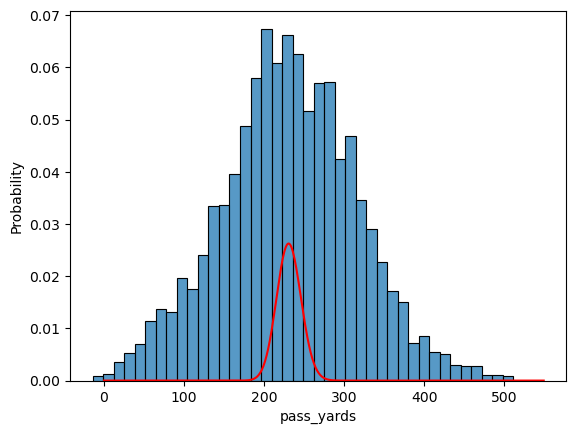

In [46]:
pass_pass_yards_y_mean = passes_pass_yards_y['pass_yards'].mean()

plot_pos = pd.DataFrame({
    "x":range(0,550),
    "expected": [poisson.pmf(x, pass_pass_yards_y_mean) for x in range(0,550)]})

sns.histplot(passes_pass_yards_y["pass_yards"], stat="probability")

plt.plot(plot_pos.x, plot_pos.expected, color='red')

plt.show()

In [17]:
# for season_idx in range(2017, 2022 + 1):
#     print(season_idx)
#     for week_idx in range(1,22 + 1):
#         print(week_idx)

In [18]:
passes_pass_td_y_geq10 = passes_pass_td_y.query("n_passes >= 10")

In [19]:
passes_pass_td_y_geq10

,season,week,passer_id,passer,pass_td_y,n_passes,total_line
0,2016,1,00-0020531,D.Brees,4.0,45,50.0
1,2016,1,00-0020679,S.Hill,0.0,35,40.0
2,2016,1,00-0021429,C.Palmer,2.0,42,44.5
3,2016,1,00-0022803,E.Manning,3.0,31,47.5
4,2016,1,00-0022924,B.Roethlisberger,3.0,38,49.0
...,...,...,...,...,...,...,...
5400,2023,21,00-0033873,P.Mahomes,1.0,50,44.0
5401,2023,21,00-0034796,L.Jackson,1.0,47,44.0
5402,2023,21,00-0037834,B.Purdy,1.0,36,52.5
5403,2023,22,00-0033873,P.Mahomes,2.0,55,47.0


In [20]:
#doesnt work
# x = pd.DataFrame()
# for season_idx in range(2016, 2023 + 1):
#     for week_idx in range(1, 22 + 1):
#         week_calc = (
#             passes_pass_td_y_geq10.query(
#                 '(season == ' + str(season_idx - 1) + ') |' + '(season ==' + str(season_idx) + "&" + 'week < ' + str(week_idx) + ')')
#                 .groupby(['passer_id', 'passer'])
#                 .agg({'pass_td_y': ['count', 'mean']})
#         )

# week_calc.columns = list(map('_'.join, week_calc.columns))

# week_calc.reset_index(inplace=True)

# week_calc.rename(columns = {
#     'pass_td_y_count': 'n_games',
#     'pass_td_y_mean': 'pass_td_rate'
# }, inplace = True)

# week_calc['season'] = season_idx
# week_calc['week'] = week_idx

# x = pd.concat([x, week_calc])
# x.describe()

In [21]:
# x[x['passer'] == 'P.Mahomes'].tail()

In [22]:
# Create DataFrame of all season-week combinations
seasons = range(2016, 2024)
weeks = range(1, 23)
season_week_combinations = pd.DataFrame([(season, week) for season in seasons for week in weeks], columns=['season', 'week'])

# Expand your original DataFrame
expanded_df = passes_pass_td_y_geq10.merge(season_week_combinations, how='cross')

# Apply the condition
expanded_df = expanded_df[((expanded_df['season_x'] == expanded_df['season_y'] - 1) | 
                          ((expanded_df['season_x'] == expanded_df['season_y']) & (expanded_df['week_x'] < expanded_df['week_y'])))]

# GroupBy and aggregate
result = (expanded_df.groupby(['passer_id', 'passer', 'season_y', 'week_y'])
          .agg(n_games=('pass_td_y', 'count'), pass_td_rate=('pass_td_y', 'mean'))
          .reset_index())

# Rename columns for clarity
result.rename(columns={'season_y': 'season', 'week_y': 'week'}, inplace=True)

In [23]:
result.describe()

,season,week,n_games,pass_td_rate
count,12529.000000,12529.000000,12529.00000,12529.000000
mean,2019.782345,12.072073,11.45670,1.153222
std,2.220619,6.286299,9.80884,0.650812
min,2016.000000,1.000000,1.00000,0.000000
25%,2018.000000,7.000000,3.00000,0.750000
50%,2020.000000,12.000000,8.00000,1.166667
75%,2022.000000,18.000000,19.00000,1.571429
max,2023.000000,22.000000,39.00000,4.000000


In [24]:
result[result['passer'] == 'P.Mahomes'].tail()

,passer_id,passer,season,week,n_games,pass_td_rate
8772,00-0033873,P.Mahomes,2023,18,36,2.083333
8773,00-0033873,P.Mahomes,2023,19,36,2.083333
8774,00-0033873,P.Mahomes,2023,20,37,2.054054
8775,00-0033873,P.Mahomes,2023,21,38,2.052632
8776,00-0033873,P.Mahomes,2023,22,39,2.025641


In [25]:
result

,passer_id,passer,season,week,n_games,pass_td_rate
0,00-0019596,T.Brady,2016,6,1,3.000000
1,00-0019596,T.Brady,2016,7,2,3.000000
2,00-0019596,T.Brady,2016,8,3,2.666667
3,00-0019596,T.Brady,2016,9,4,3.000000
4,00-0019596,T.Brady,2016,10,4,3.000000
...,...,...,...,...,...,...
12524,00-0039164,A.Richardson,2023,18,4,0.750000
12525,00-0039164,A.Richardson,2023,19,4,0.750000
12526,00-0039164,A.Richardson,2023,20,4,0.750000
12527,00-0039164,A.Richardson,2023,21,4,0.750000


In [26]:
passes_pass_td_y_geq10 = passes_pass_td_y_geq10.query('season != 2016').merge(
    result, on = ['season', 'week', 'passer_id', 'passer'], how = 'inner')

In [27]:
passes_pass_td_y_geq10

,season,week,passer_id,passer,pass_td_y,n_passes,total_line,n_games,pass_td_rate
0,2017,1,00-0019596,T.Brady,0.0,45,47.5,15,2.333333
1,2017,1,00-0020531,D.Brees,1.0,41,47.5,16,2.312500
2,2017,1,00-0021206,J.McCown,0.0,42,42.0,5,1.200000
3,2017,1,00-0021429,C.Palmer,1.0,57,48.5,15,1.733333
4,2017,1,00-0022803,E.Manning,0.0,45,46.5,17,1.588235
...,...,...,...,...,...,...,...,...,...
3874,2023,21,00-0033873,P.Mahomes,1.0,50,44.0,38,2.052632
3875,2023,21,00-0034796,L.Jackson,1.0,47,44.0,28,1.535714
3876,2023,21,00-0037834,B.Purdy,1.0,36,52.5,26,1.846154
3877,2023,22,00-0033873,P.Mahomes,2.0,55,47.0,39,2.025641


In [28]:
pass_fit = smf.glm(
    formula = 'pass_td_y ~ pass_td_rate + total_line',
    data = passes_pass_td_y_geq10,
    family = sm.families.Poisson()).fit()

In [29]:
passes_pass_td_y_geq10['expected_pass_td'] = pass_fit.predict()

In [30]:
pass_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              pass_td_y   No. Observations:                 3879
Model:                            GLM   Df Residuals:                     3876
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5685.1
Date:                Mon, 19 Feb 2024   Deviance:                       3956.4
Time:                        23:36:28   Pearson chi2:                 3.30e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.07271
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0369      0.135     -7.701      0.000      -1.301      -0.773
pass_td_rate     0.3030      0.027     11.280      0.000       0.250       0.356
total_line       0.0208      0.003      6.542      0.000       0.015       0.027
================================================================================
"""

In [31]:
passes_pass_td_y_geq10.head(15)

,season,week,passer_id,passer,pass_td_y,n_passes,total_line,n_games,pass_td_rate,expected_pass_td
0,2017,1,00-0019596,T.Brady,0.0,45,47.5,15,2.333333,1.932991
1,2017,1,00-0020531,D.Brees,1.0,41,47.5,16,2.312500,1.920826
2,2017,1,00-0021206,J.McCown,0.0,42,42.0,5,1.200000,1.222787
3,2017,1,00-0021429,C.Palmer,1.0,57,48.5,15,1.733333,1.645545
4,2017,1,00-0022803,E.Manning,0.0,45,46.5,17,1.588235,1.510536
5,2017,1,00-0022924,B.Roethlisberger,2.0,40,47.0,17,1.882353,1.668625
6,2017,1,00-0022942,P.Rivers,3.0,36,41.5,16,2.062500,1.571584
7,2017,1,00-0023436,A.Smith,4.0,40,47.5,16,1.000000,1.290504
8,2017,1,00-0023459,A.Rodgers,1.0,57,49.5,19,2.578947,2.170884
9,2017,1,00-0026143,M.Ryan,1.0,35,48.0,19,2.473684,2.038080
